In [1]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import csv
import numpy as np
%matplotlib inline

df = pd.DataFrame()

PATH = 'GTSRB/Final_Training/Images'
for label_dir in listdir(PATH):
    try: label_dir.index('000')
    except ValueError: continue
    my_path = '{}/{}/'.format(PATH, label_dir)
    df_csv = pd.read_csv('{}/GT-{}.csv'.format(my_path, label_dir), sep=';')
    df_csv['Path'] = my_path
    df = pd.concat([df, df_csv])
    

label_names = []
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        label_names.append(row[1])

del label_names[0]
        
print (label_names)


['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


In [2]:
# shuffling the samples
print (len(df))
df = df.sample(frac=1)
print (len(df))

39209
39209


Filename                       00008_00012.ppm
Width                                       96
Height                                      87
Roi.X1                                       8
Roi.Y1                                       8
Roi.X2                                      88
Roi.Y2                                      80
ClassId                                     25
Path        GTSRB/Final_Training/Images/00025/
Name: 252, dtype: object
Road work


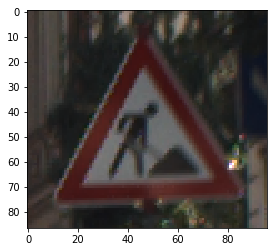

In [3]:
n = 29000
print (df.iloc[n])
print (label_names[df.iloc[n]['ClassId']])
img = misc.imread(df.iloc[n]['Path'] + df.iloc[n]['Filename'])
plt.imshow(img)


In [4]:
from math import *
TEST_PROP = 0.2

train_set = df.iloc[0: floor(len(df)*(1-TEST_PROP))]
test_set = df.iloc[floor(len(df) * (1-TEST_PROP)):]

print ('Count of train set: ', len(train_set))
print ('Count of test set: ', len(test_set))


Count of train set:  31367
Count of test set:  7842


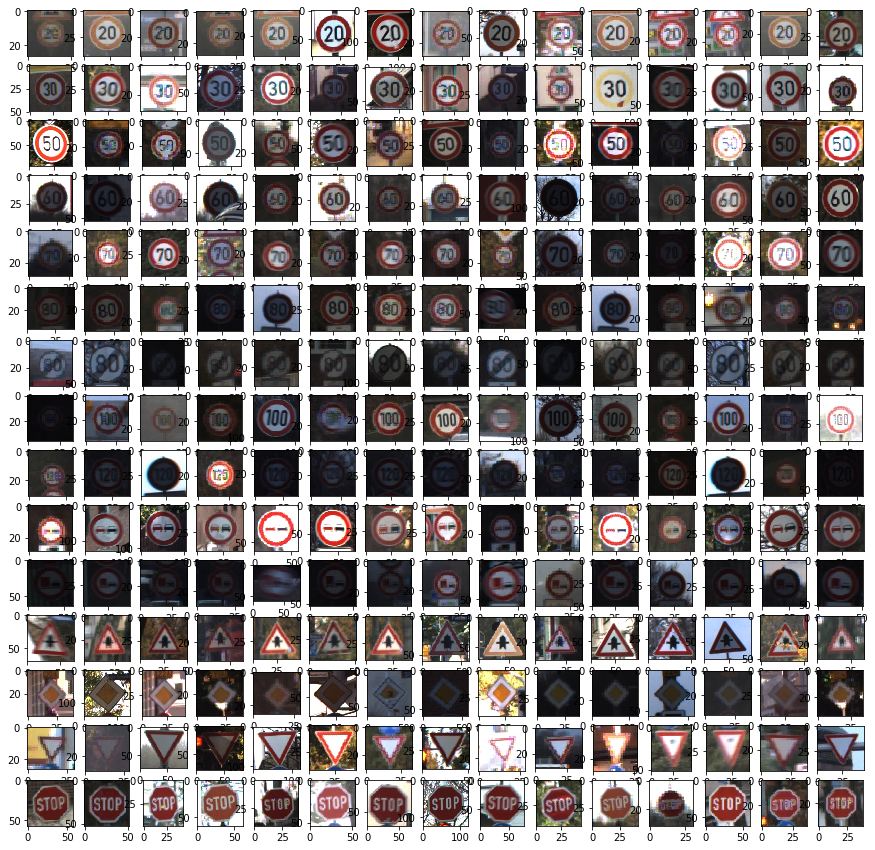

In [5]:
n = 15
c = 15
plt.figure(figsize=(15,15))
#for i in range(len(label_names)):
for i in range(n):
    selected = train_set.loc[train_set['ClassId'] == i]
    for j in range(c):
        plt.subplot(n, c, (i*c) + j+1 )
        plt.imshow(misc.imread(selected.iloc[j]['Path'] + selected.iloc[j]['Filename']))

In [43]:
from sklearn import preprocessing

NORM_W = 32
NORM_H = 32
# the generator
def generator(df, batch_size=100):
    
    while 1:
        df = df.sample(frac=1)
        X, Y = [], []
        for i in range(batch_size):
            X.append(misc.imresize(misc.imread(df.iloc[i]['Path'] + df.iloc[i]['Filename']), (NORM_W, NORM_H)))
            Y.append(df.iloc[i]['ClassId'])
       
        enc = preprocessing.LabelBinarizer()
        enc.fit(range(len(label_names)))

        yield np.float32(X), np.array(enc.transform(Y))
        

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
(3, 32, 32, 3) (3, 43)


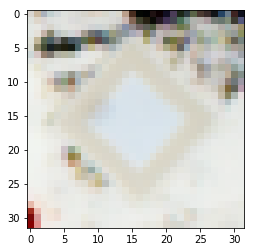

In [44]:
test_g = generator(df, batch_size = 3)

X, Y = next(test_g)

print (Y[0])
plt.imshow(X[0])
print(X.shape, Y.shape)


In [111]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K


model = Sequential()
model.add(Convolution2D(1,3,3, input_shape = (32, 32, 3)))

model.add(Convolution2D(32,3,3))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Convolution2D(64,3,3,))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Convolution2D(128,3,3,))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(Dense(1024))
model.add(Dense(43))
model.add(Activation('softmax'))


print (model.output)


Tensor("Softmax:0", shape=(?, 43), dtype=float32)


In [112]:
gen = generator(df, batch_size=50)
val_gen = generator(df, batch_size=100)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(gen, samples_per_epoch=5000, nb_epoch=10, validation_data=val_gen, nb_val_samples=100)



Epoch 1/10
5000/5000 [==============================] - 20s - loss: 15.4828 - acc: 0.0366 - val_loss: 15.6346 - val_acc: 0.0300

KeyboardInterrupt: 

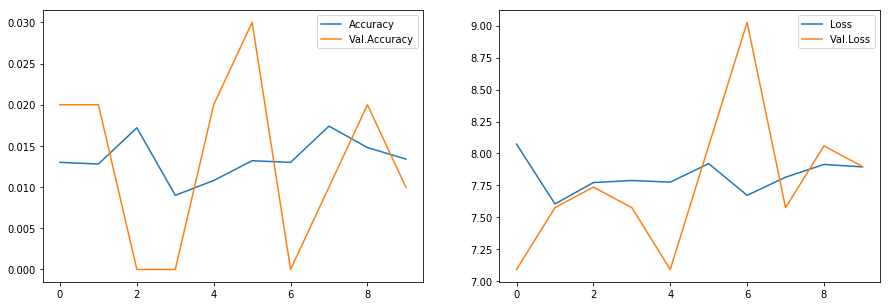

In [109]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Val.Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend()